In [1]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
raw_data = joblib.load("raw_data.job").real.swapaxes(1, 2)

In [4]:
class CNNDensityMatrix(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length
    ):
        super(CNNDensityMatrix, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # len_output_of_conv1d = timeseries_length - kernel_window + 1
        # self.fc1 = nn.Linear(len_output_of_conv1d * no_filters, no_channels)
        self.fc1 = nn.Linear(no_filters, no_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.fc1(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [6]:
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 16

kernel_window = 4










In [9]:
num_epochs = 300  # Number of training epochs

from tqdm.notebook import tqdm
import torch_optimizer as topt

opt_list = [torch.optim.Adam, torch.optim.SGD, topt.DiffGrad, topt.Lamb, topt.AdaBelief]

for opt in tqdm(opt_list):
    
    kernel_window = 3
    
    X_raw = raw_data
    y_raw = raw_data[:, :, kernel_window - 1 :]

    # Split training and validation data
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

    dataset = DensityMatrixDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    test_dataset = DensityMatrixDataset(X_val, y_val)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    
    
    model = CNNDensityMatrix(
        no_channels=C,
        no_filters=no_filters,
        kernel_window=kernel_window,
        timeseries_length=L,
    )

    model = model.to(device)



    criterion = nn.MSELoss()

    optimizer = opt(model.parameters(), lr=0.01)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(dataloader))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 500, verbose = False)
    progress_bar = tqdm(range(num_epochs), desc='Training')
    minloss = 100
    for epoch in progress_bar:
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            X, y_true = data
            X = X.to(device)
            y_true = y_true.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            y_hat = model(X)
            loss = criterion(y_true, y_hat)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            # Print statistics
            running_loss += loss.item()
            
            if i % 10 == 9:  # Print every 10 mini-batches
                # print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
                minloss = running_loss if running_loss < minloss else minloss
                running_loss = 0.0 if i!=(num_epochs-1) else running_loss
        progress_bar.set_postfix(loss=(running_loss))
    all_true = y_val

    all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()
    val_loss = criterion(tensor(all_true), tensor(all_preds))
    print("Optimizer:", opt, "Kernel:", kernel_window, f"Val Loss: {val_loss:.3e}")

  0%|          | 0/5 [00:00<?, ?it/s]

/home/Oz/miniconda3/envs/fastai2/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizer: <class 'torch.optim.adam.Adam'> Kernel: 3 Val Loss: 2.462e-08


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizer: <class 'torch.optim.sgd.SGD'> Kernel: 3 Val Loss: 1.138e-03


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizer: <class 'torch_optimizer.diffgrad.DiffGrad'> Kernel: 3 Val Loss: 1.224e-07


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizer: <class 'torch_optimizer.lamb.Lamb'> Kernel: 3 Val Loss: 4.094e-08


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizer: <class 'torch_optimizer.adabelief.AdaBelief'> Kernel: 3 Val Loss: 3.181e-07


In [101]:
all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()

In [140]:
all_true = y_val

all_preds = model(tensor(X_val).to(device)).cpu().detach().numpy()

rng = np.random.default_rng(seed=0)

In [141]:
y_hat.shape, y_true.shape, all_preds.shape, all_true.shape

(torch.Size([32, 4, 4992]),
 torch.Size([32, 4, 4992]),
 (200, 4, 4992),
 (200, 4, 4992))

In [142]:
criterion(tensor(all_true), tensor(all_preds))

tensor(4.8388e-07)

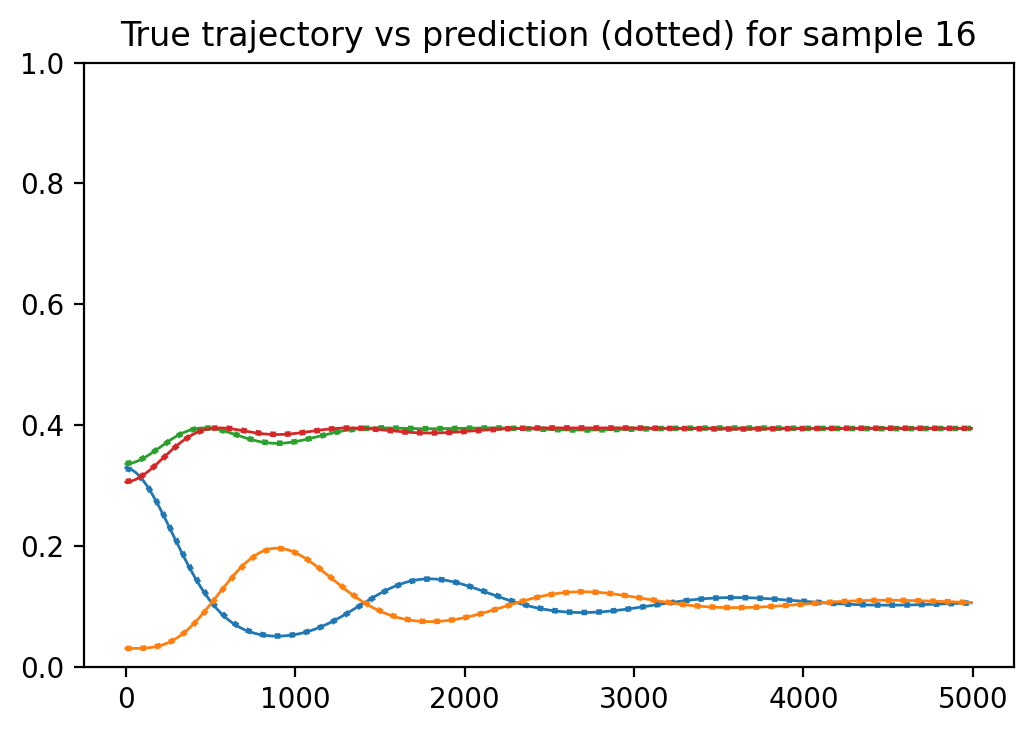

In [143]:
i = rng.integers(0, 20 - 1)

plt.figure(dpi=200)
for j in range(all_true.shape[1]):
    plt.plot(all_true[i][j], color=f'C{j}', lw=1)
    plt.plot(all_preds[i][j], ls = "dotted", color=f'C{j}', lw=2)
    plt.ylim(0,1)
plt.title(f"True trajectory vs prediction (dotted) for sample {i}")
plt.show()

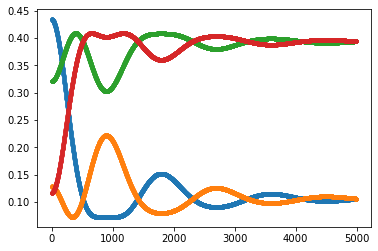

In [139]:
plt.plot((all_true[i]).T[:,:],'.');